# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import torch
import os
from glob import glob
import numpy as np
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce GTX 1650 Ti with Max-Q Design')

In [3]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 13
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

## Data preparation.

In [5]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')[2000:4500]
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')[2000:4500]
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 2500


In [6]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_masks(masks_arr, n_classes=NUM_CLASSES, size=N, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((size, H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return image, mask

In [7]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [8]:
# define transformations
from torchvision import transforms
from torch.utils.data import DataLoader

transforms = transforms.Compose([
    transforms.ToPILImage(),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
)

[INFO] found 2000 examples in the training set...
[INFO] found 500 examples in the test set...


In [9]:
uformer = uformer.to(DEVICE)
# initialize loss function and optimizer
lossFunc = losses.CharbonnierLoss()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=0.02)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [10]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for i, (x, y) in enumerate(trainLoader):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  5%|▌         | 1/20 [01:38<31:04, 98.13s/it]

[INFO] EPOCH: 1/20
Train loss: 0.078357, Test loss: 0.0562


 10%|█         | 2/20 [03:12<28:47, 95.99s/it]

[INFO] EPOCH: 2/20
Train loss: 0.046687, Test loss: 0.0426


 15%|█▌        | 3/20 [04:48<27:07, 95.75s/it]

[INFO] EPOCH: 3/20
Train loss: 0.038309, Test loss: 0.0378


 20%|██        | 4/20 [06:26<25:46, 96.67s/it]

[INFO] EPOCH: 4/20
Train loss: 0.034762, Test loss: 0.0351


 25%|██▌       | 5/20 [08:00<23:57, 95.81s/it]

[INFO] EPOCH: 5/20
Train loss: 0.033193, Test loss: 0.0337


 30%|███       | 6/20 [09:34<22:14, 95.31s/it]

[INFO] EPOCH: 6/20
Train loss: 0.032005, Test loss: 0.0333


 35%|███▌      | 7/20 [11:11<20:43, 95.67s/it]

[INFO] EPOCH: 7/20
Train loss: 0.031095, Test loss: 0.0319


 40%|████      | 8/20 [12:48<19:13, 96.13s/it]

[INFO] EPOCH: 8/20
Train loss: 0.030474, Test loss: 0.0320


 45%|████▌     | 9/20 [14:25<17:40, 96.42s/it]

[INFO] EPOCH: 9/20
Train loss: 0.030306, Test loss: 0.0313


 50%|█████     | 10/20 [16:02<16:06, 96.65s/it]

[INFO] EPOCH: 10/20
Train loss: 0.029417, Test loss: 0.0304


 55%|█████▌    | 11/20 [17:37<14:26, 96.23s/it]

[INFO] EPOCH: 11/20
Train loss: 0.028845, Test loss: 0.0302


 60%|██████    | 12/20 [19:12<12:45, 95.67s/it]

[INFO] EPOCH: 12/20
Train loss: 0.028557, Test loss: 0.0296


 65%|██████▌   | 13/20 [20:46<11:06, 95.15s/it]

[INFO] EPOCH: 13/20
Train loss: 0.028617, Test loss: 0.0294


 70%|███████   | 14/20 [22:22<09:33, 95.63s/it]

[INFO] EPOCH: 14/20
Train loss: 0.028299, Test loss: 0.0295


 75%|███████▌  | 15/20 [23:59<07:59, 95.92s/it]

[INFO] EPOCH: 15/20
Train loss: 0.027850, Test loss: 0.0290


 80%|████████  | 16/20 [25:36<06:24, 96.14s/it]

[INFO] EPOCH: 16/20
Train loss: 0.027678, Test loss: 0.0289


 85%|████████▌ | 17/20 [27:12<04:48, 96.28s/it]

[INFO] EPOCH: 17/20
Train loss: 0.027524, Test loss: 0.0291


 90%|█████████ | 18/20 [28:49<03:12, 96.45s/it]

[INFO] EPOCH: 18/20
Train loss: 0.027466, Test loss: 0.0287


 95%|█████████▌| 19/20 [30:26<01:36, 96.46s/it]

[INFO] EPOCH: 19/20
Train loss: 0.027329, Test loss: 0.0292


100%|██████████| 20/20 [32:02<00:00, 96.12s/it]

[INFO] EPOCH: 20/20
Train loss: 0.027591, Test loss: 0.0286
[INFO] total time taken to train the model: 1922.43s


In [11]:
# from timm.utils import NativeScaler
# from pytorch_Uformer import utils

# len_trainset = trainDS.__len__()
# len_valset = testDS.__len__()

# print('===> Start Epoch {} End Epoch {}'.format(0, NUM_EPOCHS))
# best_psnr = 0
# best_epoch = 0
# best_iter = 0
# eval_now = len(trainLoader)//4
# print("\nEvaluation after every {} Iterations !!!\n".format(eval_now))

# criterion = losses.CharbonnierLoss().cuda()
# loss_scaler = NativeScaler()
# torch.cuda.empty_cache()
# for epoch in range(0, NUM_EPOCHS + 1):
#     epoch_start_time = time.time()
#     epoch_loss = 0
#     train_id = 1

#     for i, data in enumerate(tqdm(trainLoader), 0): 
#         # zero_grad
#         opt.zero_grad()

#         target = data[0].cuda()
#         input_ = data[1].cuda()

#         with torch.cuda.amp.autocast():
#             restored = uformer(input_)
#             loss = criterion(restored, target)
#         loss_scaler(loss, opt, parameters=uformer.parameters())
#         epoch_loss += loss.item()

#         #### Evaluation ####
#         if (i+1)%eval_now==0 and i>0:
#             with torch.no_grad():
#                 uformer.eval()
#                 psnr_val_rgb = []
#                 for ii, data_val in enumerate((testLoader), 0):
#                     target = data_val[0].cuda()
#                     input_ = data_val[1].cuda()
#                     filenames = data_val[2]
#                     with torch.cuda.amp.autocast():
#                         restored = uformer(input_)
#                     restored = torch.clamp(restored,0,1)  
#                     psnr_val_rgb.append(utils.batch_PSNR(restored, target, False).item())

#                 psnr_val_rgb = sum(psnr_val_rgb)/ len_valset
                
#                 if psnr_val_rgb > best_psnr:
#                     best_psnr = psnr_val_rgb
#                     best_epoch = epoch
#                     best_iter = i 
#                     torch.save({'epoch': epoch, 
#                                 'state_dict': uformer.state_dict(),
#                                 'optimizer' : opt.state_dict()
#                                 }, '../models/uformer_best.pth')

#                 print("[Ep %d it %d\t PSNR SIDD: %.4f\t] ----  [best_Ep_SIDD %d best_it_SIDD %d Best_PSNR_SIDD %.4f] " % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr))

#                 uformer.train()
#                 torch.cuda.empty_cache()
#     scheduler.step()
    
#     print("------------------------------------------------------------------")
#     print("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0]))
#     print("------------------------------------------------------------------")




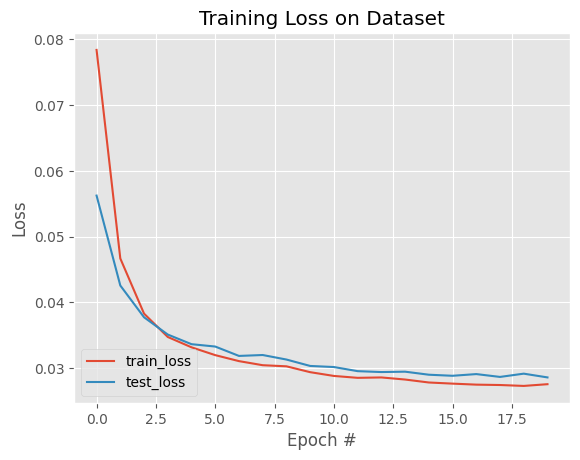

In [12]:
# plot the training loss
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
# serialize the model to disk
torch.save(uformer, '../models/uformer.pt')

In [10]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

[INFO] loading up test image paths...
[INFO] load up model...


C:\Users\alexg\AppData\Local\Temp\ipykernel_6300\2060972660.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


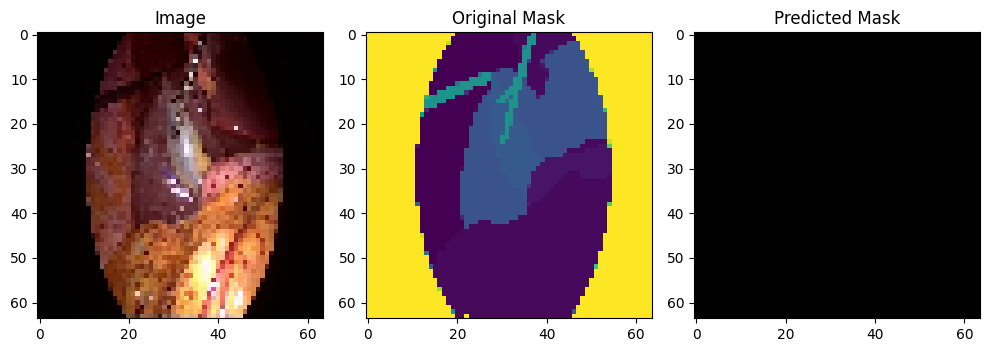

In [12]:
def make_predictions(model, imagePath, maskPath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(maskPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
		
        # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = predMask.permute(1,2,0)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)
		
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
idx = random.randint(0, len(testImages) -1 )
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
uformer = torch.load('../models/uformer.pt').to(DEVICE)

# make predictions and visualize the results
make_predictions(uformer, testImages[idx], testMasks[idx])

 --- 
 TFG - Alejandro García Mota